# Objective 01 - get permutation importances for model interpretation and feature selection


In [1]:
# import the libraries, load data and view

import pandas as pd
url = 'https://raw.githubusercontent.com/singparvi/Colab_Notebooks/master/Unit%202%20-%20Linear%20Models/Sprint%203/data/weatherAUS.csv'

weather = pd.read_csv(url)

# drop the columns with high-percentage of missing values
cols_drop = ['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
weather_drop = weather.drop(columns=cols_drop, axis=1)

# conver the date to datetimeformat and extract month only
weather_drop['Date'] = pd.to_datetime(weather_drop['Date'], infer_datetime_format=True).dt.month

In [2]:
weather

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [3]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier


numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                    'WindSpeed9am','WindSpeed3pm', 'Humidity9am',
                    'Humidity3pm', 'Pressure9am','Pressure3pm',
                    'Temp9am', 'Temp3pm']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', DecisionTreeClassifier())])

In [4]:
# Create the feature matrix
X = weather_drop.drop('RainTomorrow', axis=1)

# Create and encode the target array
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
weather_drop['RainTomorrow'].fillna('Missing', inplace=True)
print(weather_drop['RainTomorrow'].isnull().sum())
y=label_enc.fit_transform(weather_drop['RainTomorrow'])

# Import the train_test_split utility
from sklearn.model_selection import train_test_split

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the model
clf.fit(X_train,y_train)
print('Validation Accuracy', clf.score(X_test, y_test))

0
Validation Accuracy 0.760827718960539


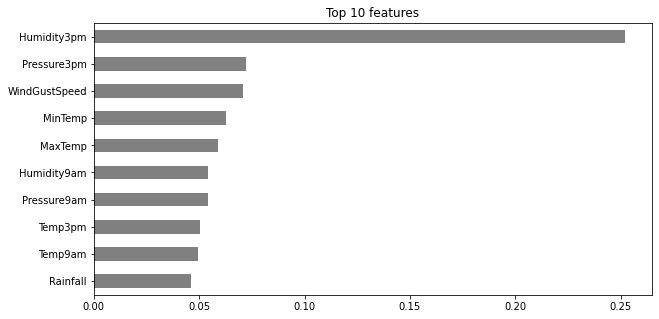

In [5]:
# Feature importances
features_order = numeric_features + categorical_features
importances = pd.Series(clf.steps[1][1].feature_importances_,features_order)

# plot feature importances
import matplotlib.pyplot as plt

n=10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

In [6]:
# Permute the values in the more important column
feature = 'Humidity3pm'

X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))


Feature permuted:  Humidity3pm
Validation Accuracy 0.760827718960539
Validation Accuracy (permuted) 0.6671937302351162


In [7]:
# Permute the values in a less important column
feature = 'WindSpeed3pm'

X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))

Feature permuted:  WindSpeed3pm
Validation Accuracy 0.760827718960539
Validation Accuracy (permuted) 0.7481438196067648


# Objective 02 - use xgboost for gradient boosting




In [8]:
# load the libraries and data

from sklearn import datasets
from sklearn.model_selection import train_test_split

# create the X, y and training test split
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4)

# import the classifier
from sklearn.ensemble import AdaBoostClassifier

ada_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=1.5, random_state=42)
ada_classifier.fit(X_train, y_train)

print('Validation accuracy: Adaboost', ada_classifier.score(X_test, y_test))

Validation accuracy: Adaboost 0.9666666666666667


In [9]:
# load xgboost and fit the model
from xgboost import XGBClassifier

xg_classifier = XGBClassifier(n_estimators=50, random_state=42)

xg_classifier.fit(X_train, y_test)
print('Validation Accuracy: Adaboost', xg_classifier.score(X_test, y_test))


XGBoostError: ignored

In [14]:
# Load xgboost and fit the model
from xgboost import XGBClassifier
import xgboost
xg_classifier = XGBClassifier(n_estimators=50, random_state=42)

xg_classifier.fit(X_train,y_train)

print('Validation Accuracy: Adaboost', xg_classifier.score(X_test, y_test))

Validation Accuracy: Adaboost 0.9833333333333333


In [15]:

xgboost.__version__

'0.90'